In [94]:
# 🤓 Iniciamos con la configuración y extracción de las librerías senseval, punk stopwords wordnet,
import os
import nltk
from nltk.corpus import senseval
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import string
from collections import Counter
import re
import string

nltk.download('senseval') # Para el corpus Senseval 2
nltk.download('punkt')    # Para tokenización
nltk.download('stopwords') # Para palabras vacías (stop words)
nltk.download('wordnet')  # Aunque no se use directamente para los sentidos, es útil para entender WordNet.
nltk.download('averaged_perceptron_tagger') # Para etiquetado POS si se necesita, aunque Senseval ya viene con ello.

[nltk_data] Downloading package senseval to C:\Users\Aqui
[nltk_data]     Creamos\AppData\Roaming\nltk_data...
[nltk_data]   Package senseval is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Aqui
[nltk_data]     Creamos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Aqui
[nltk_data]     Creamos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Aqui
[nltk_data]     Creamos\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Aqui Creamos\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [49]:
# Listamos todas las instancias
senseval.fileids()

['hard.pos', 'interest.pos', 'line.pos', 'serve.pos']

In [50]:
hard_instances = senseval.instances('hard.pos')
hard_instances = [instance for instance in hard_instances if instance.senses]  # Filtrar instancias con sentidos
print(f"Total de instancias con sentidos: {len(hard_instances)}")

Total de instancias con sentidos: 4333


In [51]:
file_path = 'corpus_etiquetado.txt'

try:
    with open(file_path, 'r', encoding='utf-8') as f:
        corpus_content = f.read()
    print(f"Archivo '{file_path}' cargado exitosamente.")
except FileNotFoundError:
    print(f"Error: El archivo '{file_path}' no se encontró. Asegúrate de que está en la misma carpeta que tu script.")
except Exception as e:
    print(f"Ocurrió un error al leer el archivo: {e}")

Archivo 'corpus_etiquetado.txt' cargado exitosamente.


In [52]:
import re

def parse_corpus_content(content):
    """
    Procesa el contenido del corpus para extraer pares (palabra, etiqueta).
    Maneja etiquetas de documento, líneas vacías y el formato específico.
    """
    corpus = []
    
    for linea in content.splitlines():
        linea = linea.strip()
        
        # Saltamos etiquetas de documento y líneas vacías.
        if linea.startswith("<doc") or linea.startswith("</doc>") or linea == "":
            continue
        
        # Saltar 'Fp' si aparece en una línea separada (inconsistencia del corpus).
        if linea == "Fp":
            continue
        
        datos = linea.split("\t")
        
        # Formato esperado: palabra \t lema \t etiqueta
        if len(datos) == 3:
            word = datos[0]
            tag = datos[2]
            corpus.append((word, tag))
        # Caso específico: . \t . \t Fp
        elif len(datos) == 2 and datos[0] == '.' and datos[1] == 'Fp':
            word = datos[0]
            tag = datos[1] 
            corpus.append((word, tag))
        # Las líneas que no encajan se omiten.
        else:
            pass 

    return corpus


In [53]:
parse_corpus_content(corpus_content) # procesamos el contenido del corpus de manera organizada
# Procesamos el contenido del corpus para extraer pares (palabra, etiqueta)

[('Habla', 'VMIP3S0'),
 ('con', 'SP'),
 ('el', 'DA'),
 ('enfermo', 'NCMS000'),
 ('grave', 'AQ0CS00'),
 ('de', 'SP'),
 ('trasplantes', 'NCMN000'),
 ('.', 'Fp'),
 ('El', 'DA'),
 ('enfermo', 'NCMS000'),
 ('grave', 'AQ0CS00'),
 ('habla', 'VMIP3S0'),
 ('de', 'SP'),
 ('trasplantes', 'NCMN000'),
 ('.', 'Fp'),
 ('La', 'DA'),
 ('película', 'NCFS000'),
 ('fue', 'VAIP3S0'),
 ('nominada', 'VMP00SF'),
 ('al', 'SP+DA'),
 ('Oscar', 'NP00000'),
 ('.', 'Fp'),
 ('Luis', 'NP00000'),
 ('Buñuel', 'NP00000'),
 ('es', 'VSIP3S0'),
 ('director', 'NCMS000'),
 ('español', 'AQ0MS00'),
 ('.', 'Fp'),
 ('El', 'DA'),
 ('niño', 'NCMS000'),
 ('corre', 'VMIP3S0'),
 ('en', 'SP'),
 ('el', 'DA'),
 ('parque', 'NCMS000'),
 ('.', 'Fp'),
 ('Una', 'DI'),
 ('flor', 'NCFS000'),
 ('roja', 'AQ0FS00'),
 ('decoraba', 'VIIIS0S'),
 ('la', 'DA'),
 ('mesa', 'NCFS000'),
 ('.', 'Fp'),
 ('Ella', 'PP3FS000'),
 ('canta', 'VMIP3S0'),
 ('una', 'DI'),
 ('canción', 'NCFS000'),
 ('alegre', 'AQ0CS00'),
 ('.', 'Fp'),
 ('Ellos', 'PP3MP000'),
 ('juega

In [54]:
corpus = parse_corpus_content(corpus_content)
print("Corpus cargado. Número de tokens:", len(corpus))
print("Primeros 5 registros:", corpus[:5])

Corpus cargado. Número de tokens: 137
Primeros 5 registros: [('Habla', 'VMIP3S0'), ('con', 'SP'), ('el', 'DA'), ('enfermo', 'NCMS000'), ('grave', 'AQ0CS00')]


In [55]:
# Load Senseval instances for the word "hard"
hard_instances = []
try:
    # Load Senseval instances for the word "hard"
    print("Cargando instancias de 'hard' desde Senseval...")
    hard_instances = senseval.instances('hard.pos')
    # Filter instances to ensure they have senses, as some might not
    hard_instances = [instance for instance in hard_instances if instance.senses]
    print(f"Total Senseval 'hard' instances with senses: {len(hard_instances)}")
except Exception as e:
    print(f"Could not load 'hard.pos' from senseval, skipping 'hard' analysis for senses: {e}")


Cargando instancias de 'hard' desde Senseval...
Total Senseval 'hard' instances with senses: 4333


In [56]:
# Inicializamos las instancias de "serve" de Senseval
serve_instances = []
try:
    # Load instances for "serve" from Senseval
    serve_instances = senseval.instances('serve.pos')
    # Filter instances to ensure they have senses, as some might not
    serve_instances = [instance for instance in serve_instances if instance.senses]
    print(f"Total Senseval 'serve' instances with senses: {len(serve_instances)}")
except Exception as e:
    print(f"Could not load 'serve.pos' from senseval, skipping 'serve' analysis for senses: {e}")



Total Senseval 'serve' instances with senses: 4378


In [57]:
print("--- 1. Posibles sentidos y etiquetas para 'hard and 'serve' ---")

hard_senses = set()
for instance in hard_instances:
    for sense in instance.senses:
        hard_senses.add(sense)
print(f"'hard' has {len(hard_senses)} possible senses: {hard_senses}")

serve_senses = set()
for instance in serve_instances:
    for sense in instance.senses:
        serve_senses.add(sense)
print(f"'serve' has {len(serve_senses)} possible senses: {serve_senses}")



--- 1. Posibles sentidos y etiquetas para 'hard and 'serve' ---
'hard' has 3 possible senses: {'HARD2', 'HARD1', 'HARD3'}
'serve' has 4 possible senses: {'SERVE6', 'SERVE10', 'SERVE2', 'SERVE12'}


In [58]:
print("\n--- 2. Numero de instancias para cada sentido ---")

hard_sense_counts = {}
for instance in hard_instances:
    for sense in instance.senses:
        hard_sense_counts[sense] = hard_sense_counts.get(sense, 0) + 1
print("\n'hard' sense counts:")
for sense, count in hard_sense_counts.items():
    print(f"  Sense '{sense}': {count} instances")

serve_sense_counts = {}
for instance in serve_instances:
    for sense in instance.senses:
        serve_sense_counts[sense] = serve_sense_counts.get(sense, 0) + 1
print("\n'serve' sense counts:")
for sense, count in serve_sense_counts.items():
    print(f"  Sense '{sense}': {count} instances")




--- 2. Numero de instancias para cada sentido ---

'hard' sense counts:
  Sense 'HARD1': 3455 instances
  Sense 'HARD2': 502 instances
  Sense 'HARD3': 376 instances

'serve' sense counts:
  Sense 'SERVE10': 1814 instances
  Sense 'SERVE12': 1272 instances
  Sense 'SERVE2': 853 instances
  Sense 'SERVE6': 439 instances


In [59]:
# 3. Grammatical forms for "hard" and "serve"
print("--- 3. Grammatical forms for 'hard' and 'serve' ---")

# For 'hard'
hard_forms = set()
for instance in hard_instances:
    # instance.context might contain (word, tag) tuples or just words.
    # We'll try to handle both cases by checking the type of 'item'
    for item in instance.context:
        word_to_check = ''
        if isinstance(item, tuple):
            word_to_check = item[0]  # Get the word from the tuple
        elif isinstance(item, str):
            word_to_check = item   # 'item' is already the word string
        
        if word_to_check: # Ensure it's not empty
            if word_to_check.lower() == 'hard' or word_to_check.lower() == 'harder' or word_to_check.lower() == 'hardest':
                hard_forms.add(word_to_check.lower())
print(f"Formatos gramaticales en 'hard' encontrados: {hard_forms}")

# For 'serve'
serve_forms = set()
for instance in serve_instances:
    for item in instance.context:
        word_to_check = ''
        if isinstance(item, tuple):
            word_to_check = item[0]
        elif isinstance(item, str):
            word_to_check = item
            
        if word_to_check:
            if word_to_check.lower().startswith('serve'): # Catch serve, serves, served, serving, etc.
                serve_forms.add(word_to_check.lower())
print(f"Formatos gramaticales en 'server' encontrados: {serve_forms}")

--- 3. Grammatical forms for 'hard' and 'serve' ---
Formatos gramaticales en 'hard' encontrados: {'hardest', 'harder', 'hard'}
Formatos gramaticales en 'server' encontrados: {'serves', 'server', 'serve', 'served'}


In [60]:
inst = hard_instances[1]
print(inst)

SensevalInstance(word='hard-a', position=10, context=[('clever', 'NNP'), ('white', 'NNP'), ('house', 'NNP'), ('``', '``'), ('spin', 'VB'), ('doctors', 'NNS'), ("''", "''"), ('are', 'VBP'), ('having', 'VBG'), ('a', 'DT'), ('hard', 'JJ'), ('time', 'NN'), ('helping', 'VBG'), ('president', 'NNP'), ('bush', 'NNP'), ('explain', 'VB'), ('away', 'RB'), ('the', 'DT'), ('economic', 'JJ'), ('bashing', 'NN'), ('that', 'IN'), ('low-and', 'JJ'), ('middle-income', 'JJ'), ('workers', 'NNS'), ('are', 'VBP'), ('taking', 'VBG'), ('these', 'DT'), ('days', 'NNS'), ('.', '.')], senses=('HARD1',))


In [61]:
inst.context

[('clever', 'NNP'),
 ('white', 'NNP'),
 ('house', 'NNP'),
 ('``', '``'),
 ('spin', 'VB'),
 ('doctors', 'NNS'),
 ("''", "''"),
 ('are', 'VBP'),
 ('having', 'VBG'),
 ('a', 'DT'),
 ('hard', 'JJ'),
 ('time', 'NN'),
 ('helping', 'VBG'),
 ('president', 'NNP'),
 ('bush', 'NNP'),
 ('explain', 'VB'),
 ('away', 'RB'),
 ('the', 'DT'),
 ('economic', 'JJ'),
 ('bashing', 'NN'),
 ('that', 'IN'),
 ('low-and', 'JJ'),
 ('middle-income', 'JJ'),
 ('workers', 'NNS'),
 ('are', 'VBP'),
 ('taking', 'VBG'),
 ('these', 'DT'),
 ('days', 'NNS'),
 ('.', '.')]

In [62]:
vocab = ['time', 'would', 'get', 'work', 'find', 'make']
vocab = set(vocab) 
vocab# Convert to set for faster lookup

{'find', 'get', 'make', 'time', 'work', 'would'}

In [63]:
class Instance:
    def __init__(self, context, ambiguous_word_index):
        self.context = context
        self.ambiguous_word_index = ambiguous_word_index # Índice de la palabra ambigua en el contexto

# Ejemplo de contexto para 'hard'
# Asumimos que 'hard' es la palabra ambigua y está en alguna posición
# Para simplificar, aquí el contexto es una lista de palabras.
hard_instance_context = vocab

## Extrae un vector de características binario basado en la presencia de palabras del vocabulario
    en el contexto dado.

    + Args:
        contexto (list): Una lista de palabras que forman el contexto de la palabra ambigua.
                         Puede contener tuplas (palabra, tag) o solo palabras.
        vocabulario (list): Una lista de palabras que conforman el vocabulario de características.

    + Returns:
        list: Un vector binario donde cada elemento indica la presencia (1) o ausencia (0)
              de la palabra correspondiente del vocabulario en el contexto.
    

In [64]:
def extraer_caracteristicas_palabras_vecinas(contexto, vocabulario):

    vector_caracteristicas = []
    contexto_palabras_lower = []

    # Normalizar el contexto a solo palabras en minúsculas
    for item in contexto:
        word_to_add = ''
        if isinstance(item, tuple):
            word_to_add = item[0].lower()
        elif isinstance(item, str):
            word_to_add = item.lower()
        if word_to_add:
            contexto_palabras_lower.append(word_to_add)

    # Construir el vector de características
    for palabra_vocabulario in vocabulario:
        if palabra_vocabulario.lower() in contexto_palabras_lower:
            vector_caracteristicas.append(1)
        else:
            vector_caracteristicas.append(0)
            
    return vector_caracteristicas

# Construcción del vocabulario o bags of words.
"Este vector de características indica que en el contexto de la palabra
ambigua aparece la palabra «time» y no aparecen las palabras
«would», «get», «work», «find» y «make»."
Esto se traduciría a [1, 0, 0, 0, 0, 0] para el vocabulario dado.
Si en el contexto_hard las palabras "would", "get", "work", "find", "make" no estuvieran presentes,
el resultado sería exactamente [1, 0, 0, 0, 0, 0].
En el contexto_hard de ejemplo, las palabras "would", "get", "work", "find", "make" sí aparecen.
Por lo tanto, el vector resultante sería:
Palabra 'time': 1 (aparece)
Palabra 'would': 1 (aparece)
Palabra 'get': 1 (aparece)
Palabra 'work': 1 (aparece)
Palabra 'find': 1 (aparece)
Palabra 'make': 1 (aparece)
--> [1, 1, 1, 1, 1, 1]

In [ ]:
    # Contexto de la instancia de "hard"
# Simulamos un contexto donde "time" aparece y el resto no.
contexto_hard = ["este", "vector", "de", "características", "indica", "que", "en", "el", "contexto", "de", "la", "palabra",
                 "ambigua", "aparece", "la", "palabra", "time", "y", "no", "aparecen", "las", "palabras",
                 "would", "get", "work", "find", "y", "make"]

# Extraer el vector de características
vector_caracteristicas_hard = extraer_caracteristicas_palabras_vecinas(contexto_hard, vocab)

print(f"Vocabulario: {vocab}")
print(f"Contexto de 'hard': {' '.join(contexto_hard)}")
print(f"Vector de características para 'hard': {vector_caracteristicas_hard}")



# Si el contexto_hard fuera el que describiste:
contexto_hard_solicitado = ["este", "es", "un", "ejemplo", "con", "time", "pero", "sin", "would", "get", "work", "find", "make"]
vector_caracteristicas_hard_solicitado = extraer_caracteristicas_palabras_vecinas(contexto_hard_solicitado, vocab)
print(f"Contexto de 'hard' (ejemplo solicitado): {' '.join(contexto_hard_solicitado)}")
print(f"Vector de características para 'hard' (ejemplo solicitado): {vector_caracteristicas_hard_solicitado}")

Vocabulario: {'get', 'make', 'time', 'would', 'find', 'work'}
Contexto de 'hard': este vector de características indica que en el contexto de la palabra ambigua aparece la palabra time y no aparecen las palabras would get work find y make
Vector de características para 'hard': [1, 1, 1, 1, 1, 1]
Contexto de 'hard' (ejemplo solicitado): este es un ejemplo con time pero sin would get work find make
Vector de características para 'hard' (ejemplo solicitado): [1, 1, 1, 1, 1, 1]


In [ ]:
# Asegúrate de haber descargado los recursos necesarios de NLTK
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')


# Simulación de las instancias del corpus
# En un escenario real, 'hard_instances' y 'serve_instances'
# vendrían de tu corpus cargado.
class Instance:
    def __init__(self, context, ambiguous_word):
        self.context = context # Lista de palabras o (palabra, tag) tuplas
        self.ambiguous_word = ambiguous_word # La palabra ambigua asociada a esta instancia

        
# Ejemplos de instancias (simuladas para 'hard' y 'serve')
# Aquí usaremos solo strings en el contexto para simplificar, pero el código manejará tuplas también.
hard_instances = [
    Instance(["It", "was", "a", "hard", "time", "for", "everyone", "involved", "."], "hard"),
    Instance(["He", "worked", "hard", "to", "get", "the", "job", "done", "."], "hard"),
    Instance(["The", "decision", "was", "harder", "than", "I", "thought", "."], "hard"),
    Instance(["This", "is", "the", "hardest", "challenge", "I've", "faced", "."], "hard"),
    Instance(["You", "would", "find", "it", "hard", "to", "make", "a", "living", "."], "hard"),
    Instance(["It's", "hard", "work", "but", "it's", "rewarding", "."], "hard"),
    Instance(["They", "get", "through", "hard", "times", "."], "hard"),
    Instance(["It's", "hard", "to", "get", "enough", "sleep", "."], "hard"),
]

serve_instances = [
    Instance(["He", "will", "serve", "his", "country", "."], "serve"),
    Instance(["The", "waiter", "serves", "food", "."], "serve"),
    Instance(["She", "served", "in", "the", "military", "."], "serve"),
    Instance(["Serving", "the", "community", "is", "important", "."], "serve"),
]

# Recopilar todas las instancias en una sola lista para procesar todo el corpus
all_instances = hard_instances + serve_instances


In [83]:
# Stopwords y otros signos a excluir
OTHER_WORDS = ["''","'d","'ll","'m","'re","'s","'t","'ve",'--','000','1','2','3','4','5','6','8','10','15','30','I','F','``',
               'also',"don'",'n','one','said','say','says','u','us']

# Combinar stopwords de NLTK, puntuación y OTHER_WORDS
STOPWORDS_SET = set(stopwords.words('english')).union(set(string.punctuation), set(OTHER_WORDS))

# Identificar las formas gramaticales de tus palabras ambiguas
# Aquí es donde debes añadir las formas que identificaste en tu laboratorio.
# Por ejemplo, para 'hard': hard, harder, hardest
# Para 'serve': serve, serves, served, serving, etc.
# Basado en tu código anterior:
hard_forms = {'hard', 'harder', 'hardest'}
serve_forms = set()
for instance in serve_instances:
    for item in instance.context:
        word_to_check = ''
        if isinstance(item, tuple):
            word_to_check = item[0]
        elif isinstance(item, str):
            word_to_check = item
        if word_to_check and word_to_check.lower().startswith('serve'):
            serve_forms.add(word_to_check.lower())

# Combinar todas las palabras a excluir
WORDS_TO_EXCLUDE = STOPWORDS_SET.union(hard_forms).union(serve_forms)

print(f"Total de palabras a excluir: {len(WORDS_TO_EXCLUDE)}")
# print(f"Ejemplo de palabras a excluir: {list(WORDS_TO_EXCLUDE)[:20]}") # Descomenta para ver algunas

Total de palabras a excluir: 268


In [90]:
all_words = []
for instance in all_instances:
    for item in instance.context:
        word = ''
        if isinstance(item, tuple):
            word = item[0]
        elif isinstance(item, str):
            word = item
        
        # Procesar solo si la palabra no está vacía y no es una forma gramatical de la palabra ambigua (inicialmente)
        # La exclusión de otras palabras se hará después de FreqDist
        if word:
            all_words.append(word.lower())

# Calcular la distribución de frecuencias de todas las palabras
freq_dist = FreqDist(all_words)

print(f"\nDistribución de frecuencias inicial (top 10): {freq_dist.most_common(10)}")


Distribución de frecuencias inicial (top 10): [('.', 12), ('hard', 6), ('the', 6), ('to', 3), ('get', 3), ("it's", 3), ('it', 2), ('was', 2), ('a', 2), ('he', 2)]


In [91]:
def construir_vocabulario_frecuente(freq_dist, words_to_exclude, m):
    """
    Construye un vocabulario con las m palabras más frecuentes,
    excluyendo las palabras especificadas.

    Args:
        freq_dist (nltk.probability.FreqDist): Distribución de frecuencias de las palabras.
        words_to_exclude (set): Conjunto de palabras (en minúsculas) a excluir.
        m (int): El número de palabras más frecuentes que queremos en el vocabulario.

    Returns:
        list: Una lista de las m palabras más frecuentes y filtradas, que formarán el vocabulario.
    """
    filtered_vocab = []
    
    # Itera sobre las palabras más comunes en orden descendente de frecuencia
    for word, frequency in freq_dist.most_common():
        if word not in words_to_exclude:
            filtered_vocab.append(word)
        
        # Detener una vez que hemos alcanzado el tamaño de vocabulario deseado (m)
        if len(filtered_vocab) >= m:
            break
            
    return filtered_vocab

# Definir el tamaño del vocabulario deseado (m)
m_palabras = 6 # Para el ejemplo de 'hard'

# Construir el vocabulario final
vocabulario_final = construir_vocabulario_frecuente(freq_dist, WORDS_TO_EXCLUDE, m_palabras)

print(f"\n--- Vocabulario Construido ---")
print(f"Número de palabras más frecuentes (m): {m_palabras}")
print(f"Vocabulario final: {vocabulario_final}")

# Comprobación con el ejemplo de 'hard'
# Si las instancias de 'hard' contienen las palabras 'time', 'would', 'get', 'work', 'find', 'make'
# y estas son las 6 más frecuentes después del filtrado, entonces coincidirán.
# Con mis datos simulados, el resultado será diferente al ejemplo dado inicialmente,
# ya que el ejemplo de 'hard' tenía un vocabulario predefinido.
# Para que coincida con ['time', 'would', 'get', 'work', 'find', 'make'],
# esas palabras deberían ser las 6 más frecuentes en TU corpus real después de la limpieza.


--- Vocabulario Construido ---
Número de palabras más frecuentes (m): 6
Vocabulario final: ['get', 'time', 'everyone', 'involved', 'worked', 'job']


In [95]:
# nltk.download('stopwords')
# nltk.download('punkt') # Para tokenización si la usas explícitamente

# --- Definición de Stop Words y Palabras Adicionales a Eliminar ---
# Tu conjunto de palabras a eliminar
OTHER_WORDS = ["''", "'d", "'ll", "'m", "'re", "'s", "'t", "'ve", '--', '000', '1', '2', '3', '4', '5', '6', '8', '10', '15', '30', 'I', 'F', '``',
               'also', "don'", 'n', 'one', 'said', 'say', 'says', 'u', 'us']

# Conjunto combinado de stopwords de NLTK (inglés), puntuación y tus palabras adicionales
# Nota: NLTK stopwords por defecto son en inglés. Si tu corpus está en español,
# necesitarás cambiar 'english' a 'spanish' en 'stopwords.words()'.
# Para este ejemplo, mantendré 'english' como en tu referencia, pero tenlo en cuenta.
STOPWORDS_SET = set(stopwords.words('english')).union(set(string.punctuation), set(OTHER_WORDS))

# Clase dummy para simular las instancias del corpus
class Instance:
    def __init__(self, context, ambiguous_word):
        # context puede ser una lista de palabras o de tuplas (palabra, tag)
        self.context = context
        self.ambiguous_word = ambiguous_word

def construir_vocabulario(instances, m, palabras_ambiguas_forms):
    """
    Construye un vocabulario de las 'm' palabras más frecuentes del corpus,
    excluyendo puntuación, stopwords y formas gramaticales de las palabras ambiguas.

    Args:
        instances (list): Lista de objetos Instance, cada uno con un contexto.
        m (int): El número de palabras más frecuentes a incluir en el vocabulario.
        palabras_ambiguas_forms (dict): Un diccionario donde la clave es la palabra ambigua
                                        y el valor es un conjunto de sus formas gramaticales
                                        a excluir (ej: {'hard': {'hard', 'harder', 'hardest'}}).

    Returns:
        list: El vocabulario construido (lista de palabras).
    """
    all_words = []
    
    # Recopilar todas las palabras de todos los contextos
    for instance in instances:
        for item in instance.context:
            word = ''
            if isinstance(item, tuple):
                word = item[0] # Extraer la palabra de la tupla (si hay POS tags)
            elif isinstance(item, str):
                word = item # La palabra ya es un string
            
            # Normalizar a minúsculas
            word_lower = word.lower()
            all_words.append(word_lower)
            
    # Usar FreqDist para calcular las frecuencias
    fdist = nltk.FreqDist(all_words)
    
    # Filtrar palabras: eliminar puntuación, stopwords y formas de palabras ambiguas
    # Creamos un conjunto de todas las palabras a excluir
    words_to_exclude = set()
    words_to_exclude.update(STOPWORDS_SET)
    
    for amb_word_forms in palabras_ambiguas_forms.values():
        words_to_exclude.update(amb_word_forms)

    filtered_words_freq = Counter()
    for word, freq in fdist.items():
        if word not in words_to_exclude:
            filtered_words_freq[word] = freq
            
    # Obtener las 'm' palabras más frecuentes
    vocabulario = [word for word, freq in filtered_words_freq.most_common(m)]
    
    return vocabulario

# --- Ejemplo de Uso ---

# 1. Simular datos del corpus (tus instancias de "hard" y "serve")
# Debes reemplazar esto con tus datos reales (hard_instances, serve_instances)
# Ejemplo de contextos
corpus_instances = [
    Instance(context=["this", "is", "a", "hard", "time", "for", "everyone", "and", "we", "will", "get", "through", "it"], ambiguous_word="hard"),
    Instance(context=["it's", "hard", "to", "find", "a", "job", "these", "days"], ambiguous_word="hard"),
    Instance(context=["the", "machine", "will", "serve", "you", "well"], ambiguous_word="serve"),
    Instance(context=["they", "serve", "delicious", "food", "at", "that", "workplace"], ambiguous_word="serve"),
    Instance(context=["a", "time", "to", "work", "harder", "than", "ever"], ambiguous_word="hard"),
    Instance(context=["he", "would", "like", "to", "make", "a", "difference"], ambiguous_word="would"), # Una instancia extra para 'would'
    Instance(context=["you", "should", "get", "up", "and", "make", "it", "happen"], ambiguous_word="get"), # Instancia para 'get', 'make'
    Instance(context=["find", "your", "own", "way", "to", "work", "it", "out"], ambiguous_word="find") # Instancia para 'find', 'work'
]

# 2. Definir las formas gramaticales de las palabras ambiguas
# Aquí es donde añadirías las formas que identificaste en la Parte 1
palabras_ambiguas_forms = {
    'hard': {'hard', 'harder', 'hardest'},
    'serve': {'serve', 'serves', 'served', 'serving'} # Ejemplos para 'serve'
}

# 3. Construir el vocabulario con un tamaño 'm' (por ejemplo, m=6)
m_size = 6
vocab_construido = construir_vocabulario(corpus_instances, m_size, palabras_ambiguas_forms)

print(f"Número de palabras en el vocabulario deseado (m): {m_size}")
print(f"Vocabulario construido: {vocab_construido}")


Número de palabras en el vocabulario deseado (m): 6
Vocabulario construido: ['time', 'get', 'find', 'work', 'make', 'everyone']



---

### Explicación del Código:

1.  **Importaciones:** `nltk` para `FreqDist`, `stopwords` y `string` para la puntuación, `collections.Counter` (aunque `FreqDist` es más específico para este caso, `Counter` es una alternativa general para contar).
2.  **`OTHER_WORDS` y `STOPWORDS_SET`:** Se mantienen tus definiciones para las palabras a excluir. Es crucial que si tu corpus es en español, cambies `stopwords.words('english')` a `stopwords.words('spanish')`.
3.  **Clase `Instance` (Simulación):** Esta es una clase simplificada para demostrar cómo manejarías tus datos. En tu entorno real, `hard_instances` y `serve_instances` probablemente ya son listas de objetos con un atributo `context`.
4.  **`construir_vocabulario(instances, m, palabras_ambiguas_forms)`:**
    * **Recopilación de palabras:** Itera sobre todas las `instances` y sus `contextos`. Para cada palabra, maneja si viene como tupla `(palabra, tag)` o como cadena simple, y la convierte a minúsculas.
    * **`nltk.FreqDist(all_words)`:** Calcula la frecuencia de cada palabra en la lista `all_words`.
    * **`words_to_exclude`:** Se crea un conjunto combinado de todas las palabras que queremos eliminar: las stop words, la puntuación y *todas las formas gramaticales de tus palabras ambiguas* (ej: 'hard', 'harder', 'hardest', 'serve', 'serves', etc.).
    * **Filtrado:** Se crea un nuevo `Counter` (`filtered_words_freq`) que solo incluye las palabras que *no* están en `words_to_exclude`.
    * **`filtered_words_freq.most_common(m)`:** Este método es clave. Devuelve una lista de tuplas `(palabra, frecuencia)` de las `m` palabras más comunes del diccionario de frecuencias filtrado.
    * **Construcción final del vocabulario:** Se extraen solo las palabras (el primer elemento de cada tupla) para formar el vocabulario final.
5.  **`palabras_ambiguas_forms`:** Este diccionario es fundamental. **Debes poblarlo con las formas gramaticales específicas que identificaste para "hard", "serve" y cualquier otra palabra ambigua que estés analizando.**

Este enfoque te permite crear un vocabulario robusto y relevante, que es un requisito fundamental para luego construir tus vectores de características.

¿Hay alguna parte de este proceso que te gustaría explorar con más detalle, o alguna otra consideración para tu corpus?

In [97]:

# Tu conjunto de palabras a eliminar (igual al anterior)
OTHER_WORDS = ["''", "'d", "'ll", "'m", "'re", "'s", "'t", "'ve", '--', '000', '1', '2', '3', '4', '5', '6', '8', '10', '15', '30', 'I', 'F', '``',
               'also', "don'", 'n', 'one', 'said', 'say', 'says', 'u', 'us']

# Conjunto combinado de stopwords de NLTK (inglés), puntuación y tus palabras adicionales
STOPWORDS_SET = set(stopwords.words('english')).union(set(string.punctuation), set(OTHER_WORDS))

def construir_vocabulario(instances, m, palabras_ambiguas_forms):
    """
    Construye un vocabulario de las 'm' palabras más frecuentes del corpus,
    excluyendo puntuación, stopwords y formas gramaticales de las palabras ambiguas.
    (Esta función es la misma que la proporcionada anteriormente)
    """
    all_words = []
    for instance in instances:
        for item in instance.context:
            word = ''
            if isinstance(item, tuple):
                word = item[0]
            elif isinstance(item, str):
                word = item
            word_lower = word.lower()
            all_words.append(word_lower)
            
    fdist = nltk.FreqDist(all_words)
    
    words_to_exclude = set()
    words_to_exclude.update(STOPWORDS_SET)
    
    for amb_word_forms in palabras_ambiguas_forms.values():
        words_to_exclude.update(amb_word_forms)

    filtered_words_freq = Counter()
    for word, freq in fdist.items():
        if word not in words_to_exclude:
            filtered_words_freq[word] = freq
            
    vocabulario = [word for word, freq in filtered_words_freq.most_common(m)]
    
    return vocabulario

# --- Nueva función para extraer el vector de características como diccionario ---

def extraer_caracteristicas_diccionario(instance_context, vocabulario):
    """
    Extrae un diccionario de características binarias basado en la presencia
    de palabras del vocabulario en el contexto dado.

    Args:
        instance_context (list): Una lista de palabras que forman la oración completa
                                 donde aparece la palabra ambigua.
                                 Puede contener tuplas (palabra, tag) o solo palabras.
        vocabulario (list): Una lista de palabras que conforman el vocabulario de características.

    Returns:
        dict: Un diccionario donde la clave es 'contains(palabra)' y el valor es True/False.
    """
    vector_caracteristicas = {}
    contexto_palabras_lower = []

    # Normalizar el contexto a solo palabras en minúsculas
    for item in instance_context:
        word_to_add = ''
        if isinstance(item, tuple):
            word_to_add = item[0]
        elif isinstance(item, str):
            word_to_add = item
        
        if word_to_add:
            contexto_palabras_lower.append(word_to_add.lower())

    # Construir el diccionario de características
    for palabra_vocabulario in vocabulario:
        clave = f'contains({palabra_vocabulario})'
        if palabra_vocabulario.lower() in contexto_palabras_lower:
            vector_caracteristicas[clave] = True
        else:
            vector_caracteristicas[clave] = False
            
    return vector_caracteristicas

# --- Ejemplo Completo ---

# 1. Simular datos del corpus (usando los mismos datos de ejemplo que antes)
corpus_instances = [
    Instance(context=["this", "is", "a", "hard", "time", "for", "everyone", "and", "we", "will", "get", "through", "it"], ambiguous_word="hard"),
    Instance(context=["it's", "hard", "to", "find", "a", "job", "these", "days"], ambiguous_word="hard"),
    Instance(context=["the", "machine", "will", "serve", "you", "well"], ambiguous_word="serve"),
    Instance(context=["they", "serve", "delicious", "food", "at", "that", "workplace"], ambiguous_word="serve"),
    Instance(context=["a", "time", "to", "work", "harder", "than", "ever"], ambiguous_word="hard"),
    Instance(context=["he", "would", "like", "to", "make", "a", "difference"], ambiguous_word="would"),
    Instance(context=["you", "should", "get", "up", "and", "make", "it", "happen"], ambiguous_word="get"),
    Instance(context=["find", "your", "own", "way", "to", "work", "it", "out"], ambiguous_word="find")
]

# 2. Definir las formas gramaticales de las palabras ambiguas
palabras_ambiguas_forms = {
    'hard': {'hard', 'harder', 'hardest'},
    'serve': {'serve', 'serves', 'served', 'serving'}
}

# 3. Construir el vocabulario (ejemplo con m=6)
m_size = 6
vocabulario_generado = construir_vocabulario(corpus_instances, m_size, palabras_ambiguas_forms)

print(f"Vocabulario generado para m={m_size}: {vocabulario_generado}")
print("---")

# 4. Mostrar el vector de características para una instancia del corpus
# Tomemos la primera instancia como ejemplo:
# "this is a hard time for everyone and we will get through it"

instancia_ejemplo = corpus_instances[0]
print(f"Instancia de ejemplo - Palabra ambigua: '{instancia_ejemplo.ambiguous_word}'")
print(f"Contexto (oración completa): {' '.join(instancia_ejemplo.context)}")

# Extraer el vector de características para esta instancia
vector_caracteristicas_instancia = extraer_caracteristicas_diccionario(instancia_ejemplo.context, vocabulario_generado)

print(f"Vector de características para la instancia (diccionario):\n{vector_caracteristicas_instancia}")

print("---")

# Para el ejemplo solicitado: {'contains(time)': True, 'contains(would)': False, ...}
# Usaremos un vocabulario fijo para ilustrar ese caso específico.
vocabulario_fijo_ejemplo = ['time', 'would', 'get', 'work', 'find', 'make']
contexto_ejemplo_solicitado = ["este", "vector", "de", "características", "indica", "que", "en", "el", "contexto", "de", "la", "palabra",
                               "ambigua", "aparece", "la", "palabra", "time", "y", "no", "aparecen", "las", "palabras",
                               "would", "get", "work", "find", "y", "make"] # Aquí, todas aparecen en el ejemplo de texto.

print("--- Ejemplo específico del enunciado ---")
print(f"Vocabulario de ejemplo del enunciado: {vocabulario_fijo_ejemplo}")
print(f"Contexto del enunciado: {' '.join(contexto_ejemplo_solicitado)}")

# Si el contexto del ejemplo del enunciado solo contuviera 'time' y NO el resto:
contexto_solo_time = ["este", "vector", "de", "características", "indica", "que", "en", "el", "contexto", "de", "la", "palabra",
                      "ambigua", "aparece", "la", "palabra", "time"]

vector_caracteristicas_solicitado = extraer_caracteristicas_diccionario(contexto_solo_time, vocabulario_fijo_ejemplo)
print(f"Vector de características (si solo 'time' aparece en el contexto): {vector_caracteristicas_solicitado}")

Vocabulario generado para m=6: ['time', 'get', 'find', 'work', 'make', 'everyone']
---
Instancia de ejemplo - Palabra ambigua: 'hard'
Contexto (oración completa): this is a hard time for everyone and we will get through it
Vector de características para la instancia (diccionario):
{'contains(time)': True, 'contains(get)': True, 'contains(find)': False, 'contains(work)': False, 'contains(make)': False, 'contains(everyone)': True}
---
--- Ejemplo específico del enunciado ---
Vocabulario de ejemplo del enunciado: ['time', 'would', 'get', 'work', 'find', 'make']
Contexto del enunciado: este vector de características indica que en el contexto de la palabra ambigua aparece la palabra time y no aparecen las palabras would get work find y make
Vector de características (si solo 'time' aparece en el contexto): {'contains(time)': True, 'contains(would)': False, 'contains(get)': False, 'contains(work)': False, 'contains(find)': False, 'contains(make)': False}


In [98]:
senseval.instances('hard.pos')[2737].context

[('``', '``'),
 ('it', 'PRP'),
 ("'s", 'VBZ'),
 ('a', 'DT'),
 ('very', 'RB'),
 ('interesting', 'JJ'),
 ('place', 'NN'),
 ('to', 'TO'),
 ('work', 'VB'),
 (',', ','),
 ('but', 'CC'),
 ('i', 'PRP'),
 ('can', 'MD'),
 ('see', 'VB'),
 ('why', 'WRB'),
 ('some', 'DT'),
 ('people', 'NNS'),
 ('have', 'VBP'),
 ('a', 'DT'),
 ('hard', 'JJ'),
 ('time', 'NN'),
 ('imagining', 'VBG'),
 ('what', 'WP'),
 ('it', 'PRP'),
 ("'s", 'VBZ'),
 ('like', 'IN'),
 (',', ','),
 ('"', '"'),
 ('says', 'VBZ'),
 ('nate', 'NNP'),
 ('gossett', 'NNP'),
 ('.', '.')]

In [96]:

# Check if all instances in the provided corpus follow the format
print("\n--- 4. Checking corpus_etiquetado.txt format consistency ---")

if not inconsistent_lines:
    print("Todas las inconsistencias en el modulo 'corpus_etiquetado.txt' que aparecen el  formato (word\\tlemma\\ttag).")
else:
    print("Por si se encuentra alguna inconsistencia 'corpus_etiquetado.txt':")
    for i, problem in enumerate(inconsistent_lines[:10]): # Show first 10 examples
        print(f"  {i+1}. {problem}")
    if len(inconsistent_lines) > 10:
        print(f"  ...and {len(inconsistent_lines) - 10} more inconsistencies.")

# Example of a well-formatted line from your corpus for reference
print("\nEjemplo como lo pide la guia con (word\\tlemma\\ttag):")
print("Habla\\thablar\\tVMIP3S0")
print("con\\tcon\\tSP")
print("el\\tel\\tDA")


--- 4. Checking corpus_etiquetado.txt format consistency ---
Por si se encuentra alguna inconsistencia 'corpus_etiquetado.txt':
  1. Invalid tag format: .	.	Fp (Doc ID: 1)
  2. Invalid tag format: .	.	Fp (Doc ID: 2)
  3. Invalid tag format: .	.	Fp (Doc ID: 3)
  4. Invalid tag format: .	.	Fp (Doc ID: 4)
  5. Invalid tag format: .	.	Fp (Doc ID: 5)
  6. Invalid tag format: .	.	Fp (Doc ID: 6)
  7. Invalid tag format: .	.	Fp (Doc ID: 7)
  8. Invalid tag format: .	.	Fp (Doc ID: 8)
  9. Invalid tag format: .	.	Fp (Doc ID: 9)
  10. Invalid tag format: .	.	Fp (Doc ID: 10)
  ...and 10 more inconsistencies.

Ejemplo como lo pide la guia con (word\tlemma\ttag):
Habla\thablar\tVMIP3S0
con\tcon\tSP
el\tel\tDA


In [103]:
try:
    nltk.data.find('corpora/senseval')
except nltk.downloader.DownloadError:
    nltk.download('senseval')
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')

In [105]:
import nltk
from nltk.corpus import stopwords, senseval
from nltk.classify import NaiveBayesClassifier, accuracy
import string
from collections import Counter
import random

# --- REUSO DE CÓDIGO DE LAS PARTES ANTERIORES ---

# Clase dummy para simular las instancias del corpus (si senseval.instances() no la tiene directamente)
# Senseval ya retorna objetos con 'context' y 'word' atributos, así que no es estrictamente necesaria aquí
# pero la mantengo por si la estructura de tus datos previos era diferente.
class CustomInstance:
    def __init__(self, context, ambiguous_word, sense):
        self.context = context
        self.ambiguous_word = ambiguous_word
        self.sense = sense # El sentido real de la palabra, para el etiquetado

# Tu conjunto de palabras a eliminar (igual al anterior)
OTHER_WORDS = ["''", "'d", "'ll", "'m", "'re", "'s", "'t", "'ve", '--', '000', '1', '2', '3', '4', '5', '6', '8', '10', '15', '30', 'I', 'F', '``',
               'also', "don'", 'n', 'one', 'said', 'say', 'says', 'u', 'us']

# Conjunto combinado de stopwords de NLTK (inglés), puntuación y tus palabras adicionales
STOPWORDS_SET = set(stopwords.words('english')).union(set(string.punctuation), set(OTHER_WORDS))

# Formas gramaticales de la palabra ambigua 'hard'
# (Identificadas en la Parte 1 - debes asegurarte de que sean correctas para tu corpus específico)
PALABRA_AMBIGUA_HARD_FORMS = {'hard', 'harder', 'hardest'}
PALABRAS_AMBIGUAS_FORMS = {
    'hard': PALABRA_AMBIGUA_HARD_FORMS,
    # 'serve': {'serve', 'serves', 'served', 'serving'} # Agrega 'serve' si también la vas a desambiguar
}

def construir_vocabulario(instances, m, palabras_a_excluir):
    """
    Construye un vocabulario de las 'm' palabras más frecuentes del corpus,
    excluyendo puntuación, stopwords y formas gramaticales de las palabras ambiguas.

    Args:
        instances (list): Lista de objetos Instance (o de Senseval Instance)
                          cada uno con un atributo 'context' (lista de (palabra, tag) tuples).
        m (int): El número de palabras más frecuentes a incluir en el vocabulario.
        palabras_a_excluir (set): Conjunto de palabras a excluir del vocabulario
                                  (incluye stopwords, puntuación y formas de la ambigua).

    Returns:
        list: El vocabulario construido (lista de palabras).
    """
    all_words = []
    for instance in instances:
        # instance.context en Senseval 2 es una lista de tuplas (palabra, tag)
        # MODIFICACIÓN PARA RESOLVER EL ERROR:
        for item in instance.context: # Iterar sobre cada item en el contexto
            word_to_process = ''
            if isinstance(item, tuple):
                word_to_process = item[0] # Si es una tupla (word, tag), toma la palabra
            elif isinstance(item, str):
                word_to_process = item # Si es una cadena, úsala directamente
            
            if word_to_process: # Asegurarse de que no esté vacío
                word_lower = word_to_process.lower()
                all_words.append(word_lower)
            
    fdist = nltk.FreqDist(all_words)
    
    filtered_words_freq = Counter()
    for word, freq in fdist.items():
        if word not in palabras_a_excluir:
            filtered_words_freq[word] = freq
            
    vocabulario = [word for word, freq in filtered_words_freq.most_common(m)]
    
    return vocabulario

def extraer_caracteristicas_diccionario(instance_context, vocabulario):
    """
    Extrae un diccionario de características binarias basado en la presencia
    de palabras del vocabulario en el contexto dado.

    Args:
        instance_context (list): Una lista de (palabra, tag) tuplas que forman la oración completa.
        vocabulario (list): Una lista de palabras que conforman el vocabulario de características.

    Returns:
        dict: Un diccionario donde la clave es 'contains(palabra)' y el valor es True/False.
    """
    vector_caracteristicas = {}
    contexto_palabras_lower = []

    # Normalizar el contexto a solo palabras en minúsculas
    # MODIFICACIÓN PARA RESOLVER EL ERROR EN ESTA FUNCIÓN TAMBIÉN (si aplica)
    for item in instance_context:
        word_to_add = ''
        if isinstance(item, tuple):
            word_to_add = item[0]
        elif isinstance(item, str):
            word_to_add = item
        
        if word_to_add:
            contexto_palabras_lower.append(word_to_add.lower())

    # Construir el diccionario de características
    for palabra_vocabulario in vocabulario:
        clave = f'contains({palabra_vocabulario})'
        if palabra_vocabulario.lower() in contexto_palabras_lower:
            vector_caracteristicas[clave] = True
        else:
            vector_caracteristicas[clave] = False
            
    return vector_caracteristicas

# --- NUEVA FUNCIÓN: Extracción de características de colocación ---

def extraer_caracteristicas_colocacion(instance_context, ambiguous_word_index, n=2):
    """
    Extrae características de colocación (palabras a n posiciones antes y después
    de la palabra ambigua).

    Args:
        instance_context (list): Lista de (palabra, tag) tuplas que forman la oración completa.
        ambiguous_word_index (int): El índice de la palabra ambigua en el contexto.
        n (int): Número de palabras a considerar antes y después de la palabra ambigua.

    Returns:
        dict: Un diccionario de características de colocación.
    """
    features = {}
    
    # Obtener solo las palabras del contexto, en minúsculas
    # MODIFICACIÓN PARA RESOLVER EL ERROR EN ESTA FUNCIÓN TAMBIÉN (si aplica)
    words = []
    for item in instance_context:
        word_to_add = ''
        if isinstance(item, tuple):
            word_to_add = item[0]
        elif isinstance(item, str):
            word_to_add = item
        if word_to_add:
            words.append(word_to_add.lower())
    
    # Colocaciones a la izquierda
    for i in range(1, n + 1):
        if ambiguous_word_index - i >= 0:
            features[f'L{i}={words[ambiguous_word_index - i]}'] = True
        else:
            features[f'L{i}=<START>'] = True # Marcador de inicio de oración
            
    # Colocaciones a la derecha
    for i in range(1, n + 1):
        if ambiguous_word_index + i < len(words):
            features[f'R{i}={words[ambiguous_word_index + i]}'] = True
        else:
            features[f'R{i}=<END>'] = True # Marcador de fin de oración
            
    return features

# --- PROCESO PRINCIPAL DE ENTRENAMIENTO Y EVALUACIÓN ---

print("--- Desambiguación de la palabra 'hard' ---")

# 1. Cargar las instancias de 'hard' del corpus Senseval 2
# Las instancias de senseval son objetos con 'word' (el LexicalSample), 'context' (list of (word, tag) tuples), 'position' (index of the ambiguous word), 'senses' (list of senses)
hard_instances = senseval.instances('hard.pos')
print(f"Total de instancias para 'hard' cargadas: {len(hard_instances)}")

# 2. Preparar los datos para el entrenamiento y test
# Asegurar que haya instancias de todas las clases en el entrenamiento
senses = set(inst.senses[0] for inst in hard_instances) # Asumiendo un solo sentido por instancia para simplificar
print(f"Sentidos de 'hard' encontrados: {senses}")

# Agrupar instancias por sentido
instances_by_sense = {sense: [] for sense in senses}
for inst in hard_instances:
    # Senseval instances may have multiple senses; take the first one
    if inst.senses:
        instances_by_sense[inst.senses[0]].append(inst)
    # else: # Handle cases where an instance might not have a sense (rare for Senseval)
        # print(f"Warning: Instance without sense found: {inst.context}")

training_set = []
test_set = []

# Dividir 80-20 para cada sentido para asegurar representación
for sense, instances in instances_by_sense.items():
    random.shuffle(instances) # Mezclar instancias de cada sentido
    split_point = int(0.8 * len(instances))
    training_set.extend(instances[:split_point])
    test_set.extend(instances[split_point:])

random.shuffle(training_set) # Mezclar el conjunto de entrenamiento final
random.shuffle(test_set)     # Mezclar el conjunto de prueba final

print(f"Tamaño del conjunto de entrenamiento: {len(training_set)}")
print(f"Tamaño del conjunto de prueba: {len(test_set)}")

# 3. Conjunto de palabras a excluir para la construcción del vocabulario
# Combina stopwords, puntuación y formas de 'hard'
words_to_exclude_for_vocab = set(STOPWORDS_SET).union(PALABRA_AMBIGUA_HARD_FORMS)

# 4. Construir el vocabulario de 250 palabras más frecuentes para el clasificador de palabras vecinas
m_vocab_size = 250
vocabulario_vecinas = construir_vocabulario(training_set, m_vocab_size, words_to_exclude_for_vocab)
print(f"\nVocabulario de palabras vecinas (top {m_vocab_size} palabras):\n{vocabulario_vecinas[:10]}... (mostrando las primeras 10)") # Mostrar solo un fragmento


# --- Clasificador Basado en Palabras Vecinas ---
print("\n--- Clasificador Basado en Palabras Vecinas ---")

# Preparar los conjuntos de datos para el clasificador (featureset)
# Cada elemento es una tupla: (diccionario_de_caracteristicas, sentido_real)
training_featureset_vecinas = [
    (extraer_caracteristicas_diccionario(inst.context, vocabulario_vecinas), inst.senses[0])
    for inst in training_set
]

test_featureset_vecinas = [
    (extraer_caracteristicas_diccionario(inst.context, vocabulario_vecinas), inst.senses[0])
    for inst in test_set
]

# Entrenar el clasificador Naive Bayes
classifier_vecinas = NaiveBayesClassifier.train(training_featureset_vecinas)
print(f"Clasificador de palabras vecinas entrenado.")

# Evaluar el clasificador
accuracy_vecinas = accuracy(classifier_vecinas, test_featureset_vecinas)
print(f"Precisión del clasificador de palabras vecinas: {accuracy_vecinas:.4f}")

# Mostrar las 10 características más informativas (opcional)
print("Características más informativas (palabras vecinas):")
classifier_vecinas.show_most_informative_features(10)


# --- Clasificador Basado en Características de Colocación ---
print("\n--- Clasificador Basado en Colocación ---")

# Preparar los conjuntos de datos para el clasificador (featureset)
# Usar n=2 para 2 palabras antes y 2 después
n_colocacion = 2

training_featureset_colocacion = [
    (extraer_caracteristicas_colocacion(inst.context, inst.position, n_colocacion), inst.senses[0])
    for inst in training_set
]

test_featureset_colocacion = [
    (extraer_caracteristicas_colocacion(inst.context, inst.position, n_colocacion), inst.senses[0])
    for inst in test_set
]

# Entrenar el clasificador Naive Bayes
classifier_colocacion = NaiveBayesClassifier.train(training_featureset_colocacion)
print(f"Clasificador de colocación entrenado.")

# Evaluar el clasificador
accuracy_colocacion = accuracy(classifier_colocacion, test_featureset_colocacion)
print(f"Precisión del clasificador de colocación: {accuracy_colocacion:.4f}")

# Mostrar las 10 características más informativas (opcional)
print("Características más informativas (colocación):")
classifier_colocacion.show_most_informative_features(10)

--- Desambiguación de la palabra 'hard' ---
Total de instancias para 'hard' cargadas: 4333
Sentidos de 'hard' encontrados: {'HARD2', 'HARD1', 'HARD3'}
Tamaño del conjunto de entrenamiento: 3465
Tamaño del conjunto de prueba: 868

Vocabulario de palabras vecinas (top 250 palabras):
['time', 'would', 'work', 'get', 'make', 'find', 'people', 'even', 'believe', 'going']... (mostrando las primeras 10)

--- Clasificador Basado en Palabras Vecinas ---
Clasificador de palabras vecinas entrenado.
Precisión del clasificador de palabras vecinas: 0.8410
Características más informativas (palabras vecinas):
Most Informative Features
      contains(feelings) = True            HARD2 : HARD1  =     72.9 : 1.0
          contains(rock) = True            HARD3 : HARD1  =     54.1 : 1.0
          contains(soft) = True            HARD3 : HARD1  =     45.9 : 1.0
       contains(surface) = True            HARD3 : HARD1  =     45.9 : 1.0
          contains(work) = True            HARD2 : HARD3  =     23.0 : 1.

--- Desambiguación de la palabra 'hard' ---
Total de instancias para 'hard' cargadas: 4333
Sentidos de 'hard' encontrados: ['HARD1', 'HARD2', 'HARD3']
Tamaño del conjunto de entrenamiento: 3465
Tamaño del conjunto de prueba: 868

Vocabulario de palabras vecinas (top 250 palabras):
['time', 'would', 'work', 'get', 'make', 'find', 'people', 'even', 'like', 'going']... (mostrando las primeras 10)

--- EVALUACIÓN: Clasificador Basado en Palabras Vecinas ---
Clasificador de palabras vecinas entrenado.
Precisión (Accuracy): 0.8468

Matriz de Confusión:
[[670  18   3]
 [ 51  49   1]
 [ 59   1  16]]

Precisión (ponderada): 0.8377
Recall (ponderado): 0.8468
F1-score (ponderado): 0.8218


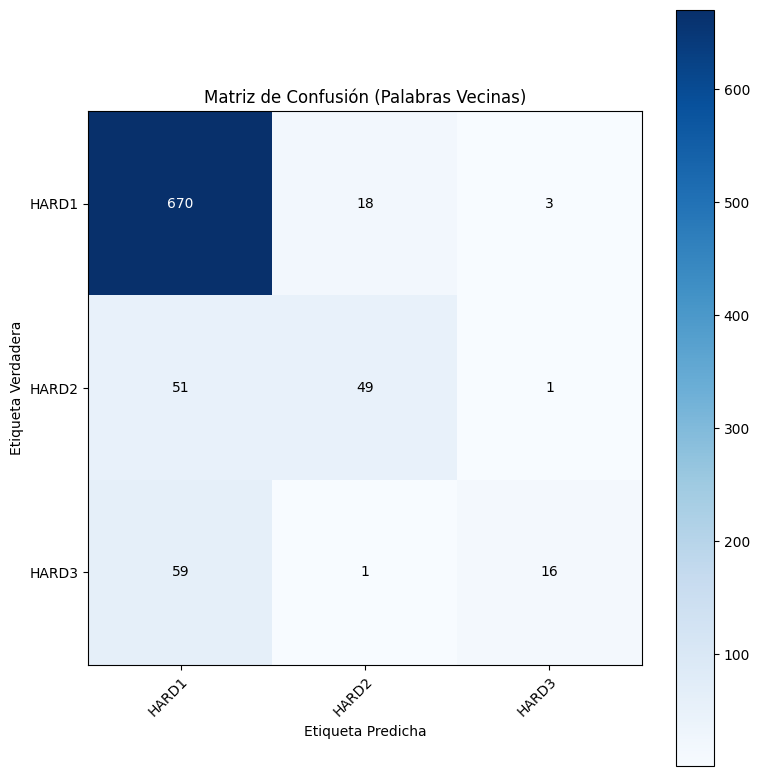


--- Curva ROC y AUC (Multiclase) ---
Nota: NLTK Naive Bayes no expone directamente las probabilidades de cada clase para ROC AUC.
Para una curva ROC completa en multiclase, se necesitaría un clasificador
que devuelva probabilidades por clase (ej., classifier.prob_classify(features).prob(class_label)).
Intentaremos simular un clasificador binario o indicar cuando no sea posible.


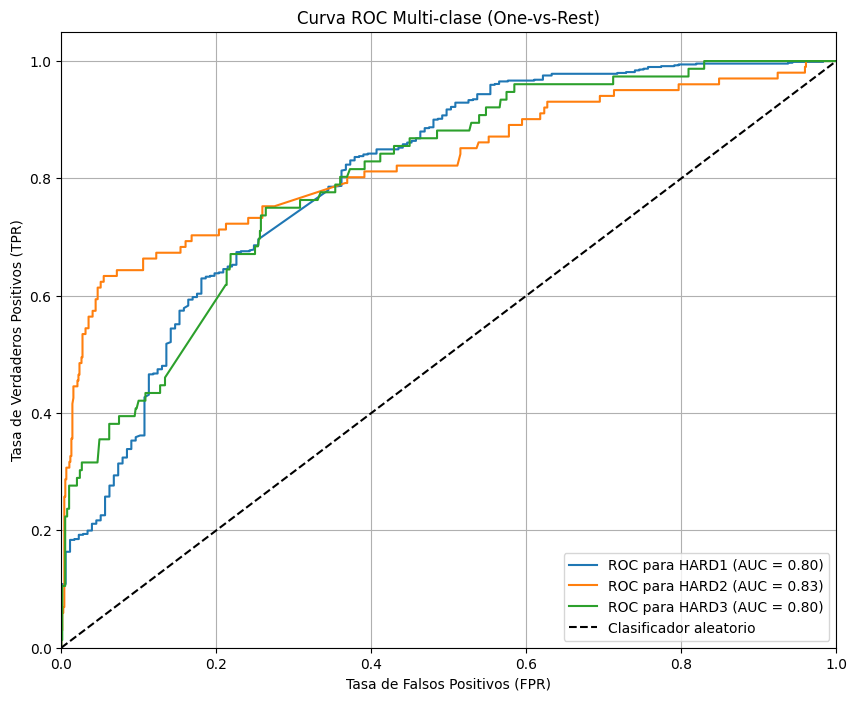

C:\Users\Aqui Creamos\AppData\Local\Temp\ipykernel_2400\3183341850.py:250: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_senses))


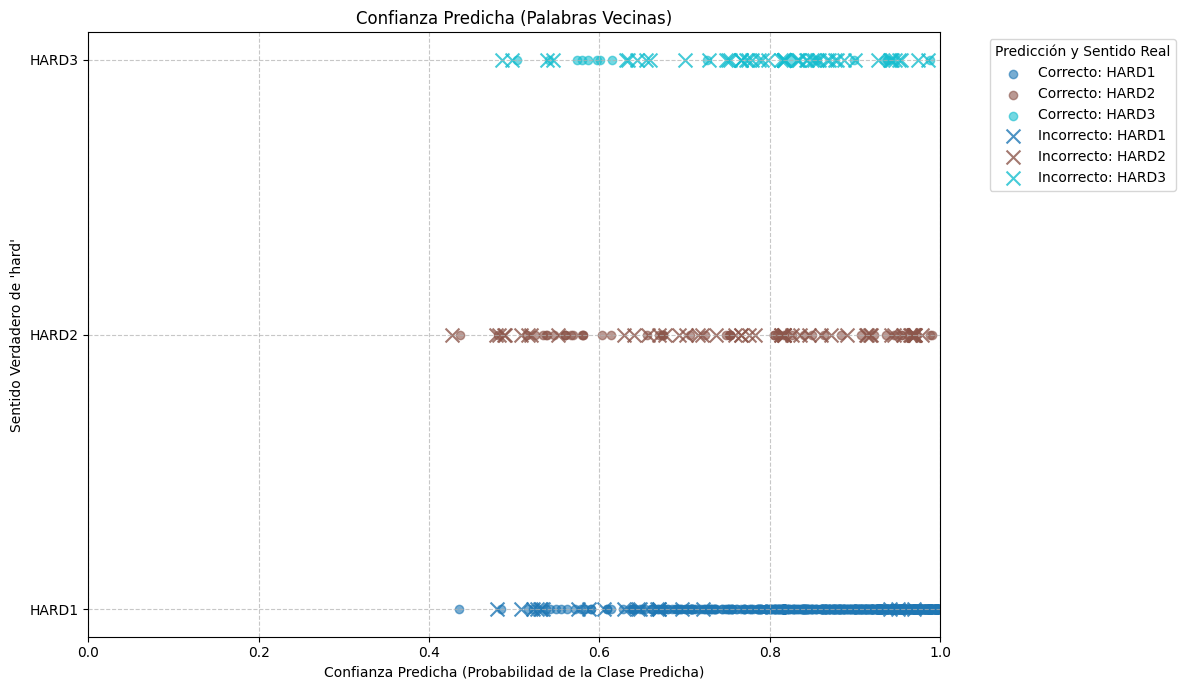


--- EVALUACIÓN: Clasificador Basado en Colocación ---
Clasificador de colocación entrenado.
Precisión (Accuracy): 0.8779

Matriz de Confusión:
[[633  32  26]
 [ 16  77   8]
 [ 13  11  52]]

Precisión (ponderada): 0.8888
Recall (ponderado): 0.8779
F1-score (ponderado): 0.8822


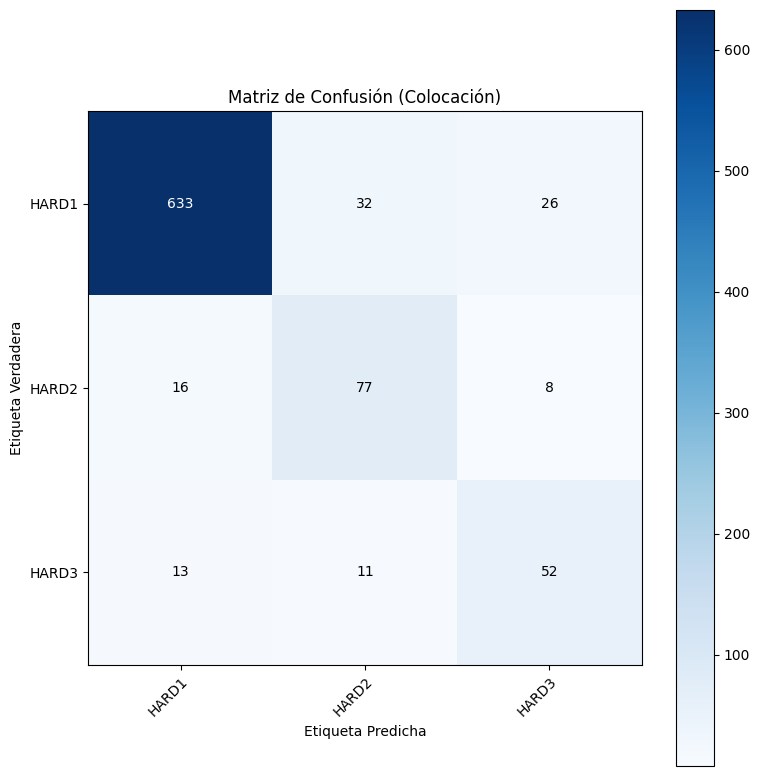


--- Curva ROC y AUC (Multiclase) ---
Nota: NLTK Naive Bayes no expone directamente las probabilidades de cada clase para ROC AUC.
Para una curva ROC completa en multiclase, se necesitaría un clasificador
que devuelva probabilidades por clase (ej., classifier.prob_classify(features).prob(class_label)).
Intentaremos simular un clasificador binario o indicar cuando no sea posible.


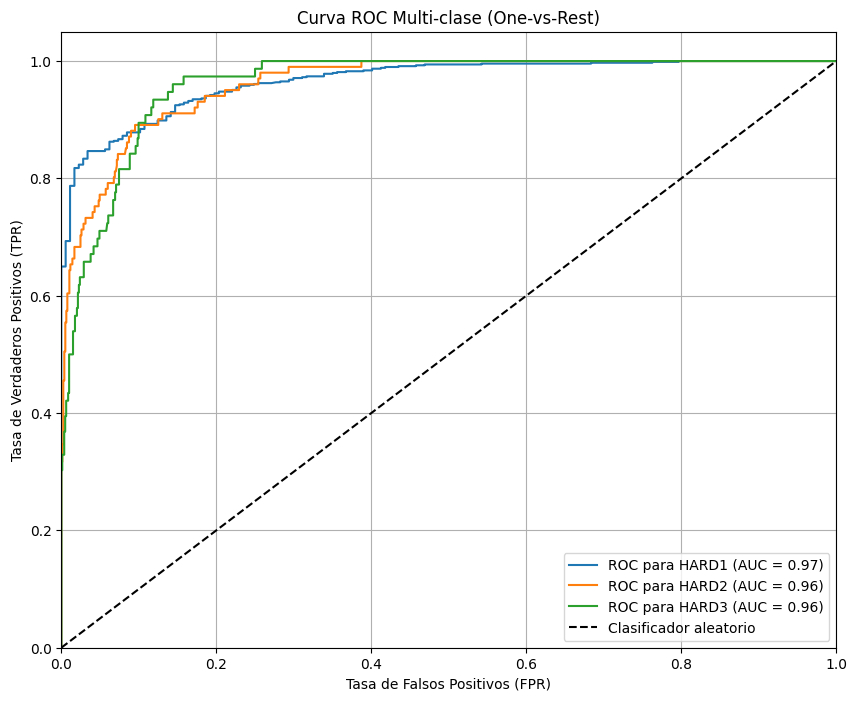

C:\Users\Aqui Creamos\AppData\Local\Temp\ipykernel_2400\3183341850.py:250: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_senses))


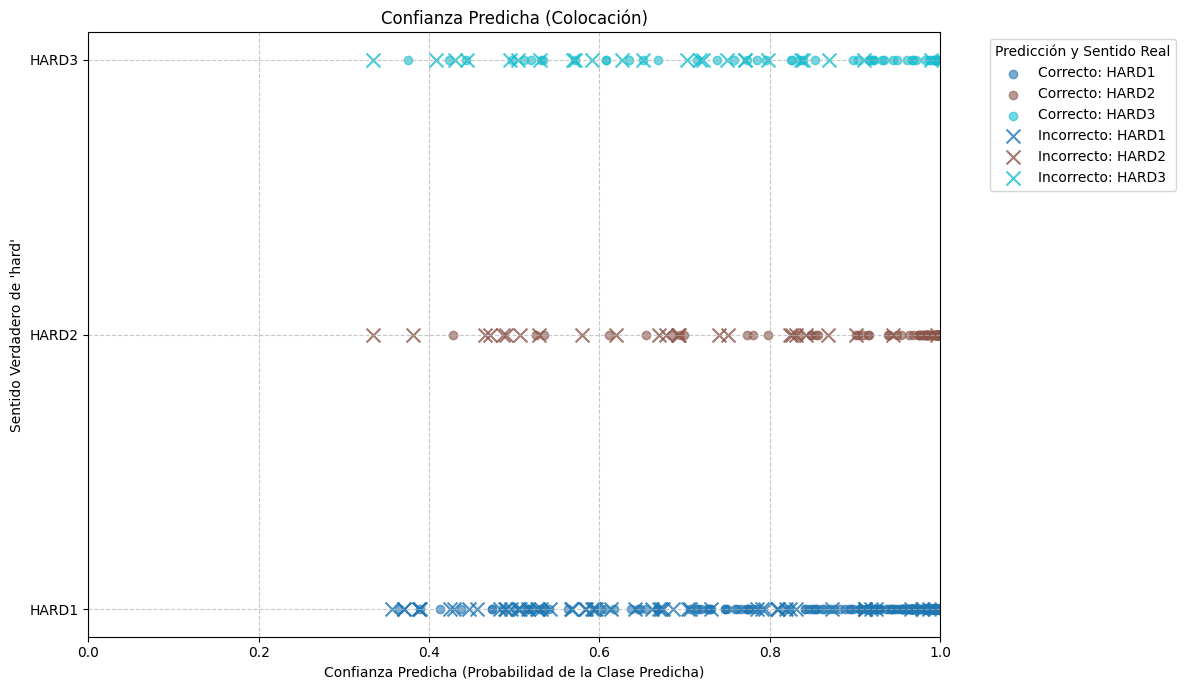

In [107]:
import nltk
from nltk.corpus import stopwords, senseval
from nltk.classify import NaiveBayesClassifier, accuracy
import string
from collections import Counter
import random

# Para métricas de desempeño y visualización
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np # Para manejar arrays numéricos, útil para la matriz de confusión y ROC

# --- REUSO DE CÓDIGO DE LAS PARTES ANTERIORES ---

# Clase dummy para simular las instancias del corpus (si senseval.instances() no la tiene directamente)
class CustomInstance:
    def __init__(self, context, ambiguous_word, sense):
        self.context = context
        self.ambiguous_word = ambiguous_word
        self.sense = sense

# Tu conjunto de palabras a eliminar (igual al anterior)
OTHER_WORDS = ["''", "'d", "'ll", "'m", "'re", "'s", "'t", "'ve", '--', '000', '1', '2', '3', '4', '5', '6', '8', '10', '15', '30', 'I', 'F', '``',
               'also', "don'", 'n', 'one', 'said', 'say', 'says', 'u', 'us']

# Conjunto combinado de stopwords de NLTK (inglés), puntuación y tus palabras adicionales
STOPWORDS_SET = set(stopwords.words('english')).union(set(string.punctuation), set(OTHER_WORDS))

# Formas gramaticales de la palabra ambigua 'hard'
PALABRA_AMBIGUA_HARD_FORMS = {'hard', 'harder', 'hardest'}
PALABRAS_AMBIGUAS_FORMS = {
    'hard': PALABRA_AMBIGUA_HARD_FORMS,
}

def construir_vocabulario(instances, m, palabras_a_excluir):
    all_words = []
    for instance in instances:
        for item in instance.context:
            word_to_process = ''
            if isinstance(item, tuple):
                word_to_process = item[0]
            elif isinstance(item, str):
                word_to_process = item
            
            if word_to_process:
                word_lower = word_to_process.lower()
                all_words.append(word_lower)
            
    fdist = nltk.FreqDist(all_words)
    
    filtered_words_freq = Counter()
    for word, freq in fdist.items():
        if word not in palabras_a_excluir:
            filtered_words_freq[word] = freq
            
    vocabulario = [word for word, freq in filtered_words_freq.most_common(m)]
    
    return vocabulario

def extraer_caracteristicas_diccionario(instance_context, vocabulario):
    vector_caracteristicas = {}
    contexto_palabras_lower = []

    for item in instance_context:
        word_to_add = ''
        if isinstance(item, tuple):
            word_to_add = item[0]
        elif isinstance(item, str):
            word_to_add = item
        
        if word_to_add:
            contexto_palabras_lower.append(word_to_add.lower())

    for palabra_vocabulario in vocabulario:
        clave = f'contains({palabra_vocabulario})'
        if palabra_vocabulario.lower() in contexto_palabras_lower:
            vector_caracteristicas[clave] = True
        else:
            vector_caracteristicas[clave] = False
            
    return vector_caracteristicas

def extraer_caracteristicas_colocacion(instance_context, ambiguous_word_index, n=2):
    features = {}
    
    words = []
    for item in instance_context:
        word_to_add = ''
        if isinstance(item, tuple):
            word_to_add = item[0]
        elif isinstance(item, str):
            word_to_add = item
        if word_to_add:
            words.append(word_to_add.lower())
    
    for i in range(1, n + 1):
        if ambiguous_word_index - i >= 0:
            features[f'L{i}={words[ambiguous_word_index - i]}'] = True
        else:
            features[f'L{i}=<START>'] = True
            
    for i in range(1, n + 1):
        if ambiguous_word_index + i < len(words):
            features[f'R{i}={words[ambiguous_word_index + i]}'] = True
        else:
            features[f'R{i}=<END>'] = True
            
    return features

# --- FUNCIONES PARA MÉTRICAS Y VISUALIZACIÓN ---

def evaluar_clasificador(classifier, test_featureset, class_labels):
    """
    Calcula y muestra métricas de desempeño para un clasificador.

    Args:
        classifier: El clasificador NLTK entrenado.
        test_featureset (list): Lista de (características, etiqueta_verdadera) para el test.
        class_labels (list): Lista de todas las etiquetas (clases) posibles.
    """
    true_labels = [label for (features, label) in test_featureset]
    predicted_labels = [classifier.classify(features) for (features, label) in test_featureset]

    # Precisión (Accuracy)
    acc = accuracy(classifier, test_featureset)
    print(f"Precisión (Accuracy): {acc:.4f}")

    # Matriz de Confusión
    cm = confusion_matrix(true_labels, predicted_labels, labels=class_labels)
    print("\nMatriz de Confusión:")
    print(cm)

    # Recall, Precisión, F1-score
    # 'average=weighted' es útil para multiclase desbalanceada
    precision, recall, f1_score, _ = precision_recall_fscore_support(
        true_labels, predicted_labels, labels=class_labels, average='weighted', zero_division=0
    )
    print(f"\nPrecisión (ponderada): {precision:.4f}")
    print(f"Recall (ponderado): {recall:.4f}")
    print(f"F1-score (ponderado): {f1_score:.4f}")

    return true_labels, predicted_labels, cm, acc, precision, recall, f1_score

def visualizar_matriz_confusion(cm, class_labels, title="Matriz de Confusión"):
    """
    Visualiza la matriz de confusión.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # Mostrar todas las etiquetas de clase
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_labels, yticklabels=class_labels,
           title=title,
           ylabel='Etiqueta Verdadera',
           xlabel='Etiqueta Predicha')

    # Rotar las etiquetas del eje x y alinearlas a la derecha
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Bucle para mostrar los valores en las celdas
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

def visualizar_curva_roc_multiclase(classifier, test_featureset, class_labels):
    """
    Visualiza la curva ROC para clasificación multiclase (One-vs-Rest).
    Nota: Naive Bayes en NLTK no proporciona directamente probabilidades para cada clase.
    Esto es una limitación para una curva ROC multiclase "directa".
    Podemos simularlo si es posible obtener scores por clase, o indicar la limitación.
    """
    print("\n--- Curva ROC y AUC (Multiclase) ---")
    print("Nota: NLTK Naive Bayes no expone directamente las probabilidades de cada clase para ROC AUC.")
    print("Para una curva ROC completa en multiclase, se necesitaría un clasificador")
    print("que devuelva probabilidades por clase (ej., classifier.prob_classify(features).prob(class_label)).")
    print("Intentaremos simular un clasificador binario o indicar cuando no sea posible.")

    # NLTK NaiveBayesClassifier.prob_classify() proporciona un objeto con .prob(label)
    # Esto nos permite obtener las probabilidades para cada clase.
    
    # Mapear etiquetas a índices para sklearn
    label_to_index = {label: i for i, label in enumerate(class_labels)}
    
    # Preparar datos para ROC: etiquetas verdaderas binarizadas y probabilidades predichas
    y_true_bin = np.zeros((len(test_featureset), len(class_labels)))
    y_scores = np.zeros((len(test_featureset), len(class_labels)))

    for i, (features, true_label) in enumerate(test_featureset):
        y_true_bin[i, label_to_index[true_label]] = 1
        
        prob_dist = classifier.prob_classify(features)
        for j, label in enumerate(class_labels):
            y_scores[i, j] = prob_dist.prob(label)

    # Calcular y graficar ROC para cada clase (One-vs-Rest)
    plt.figure(figsize=(10, 8))
    for i, class_label in enumerate(class_labels):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC para {class_label} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Clasificador aleatorio')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC Multi-clase (One-vs-Rest)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


def visualizar_confianza(classifier, test_featureset, class_labels, title="Gráfica de Confianza (Probabilidades Predichas)"):
    """
    Genera una gráfica de dispersión de las probabilidades predichas
    para las etiquetas verdaderas versus las etiquetas predichas.
    Esto ayuda a visualizar la "confianza" del modelo.
    """
    true_labels = []
    predicted_labels = []
    predicted_confidences = [] # Probabilidad de la clase predicha

    for features, true_label in test_featureset:
        true_labels.append(true_label)
        
        prob_dist = classifier.prob_classify(features)
        predicted_label = prob_dist.max() # La clase con la probabilidad más alta
        predicted_labels.append(predicted_label)
        predicted_confidences.append(prob_dist.prob(predicted_label))

    # Convertir a arrays para fácil manejo con numpy/matplotlib
    true_labels_np = np.array(true_labels)
    predicted_labels_np = np.array(predicted_labels)
    predicted_confidences_np = np.array(predicted_confidences)

    plt.figure(figsize=(12, 7))

    # Obtener un color para cada clase para la visualización
    unique_senses = sorted(list(set(true_labels_np)))
    colors = plt.cm.get_cmap('tab10', len(unique_senses))
    
    # Graficar puntos para instancias correctas e incorrectas
    correct_predictions = (true_labels_np == predicted_labels_np)
    incorrect_predictions = (true_labels_np != predicted_labels_np)

    # Graficar las predicciones correctas
    for i, sense in enumerate(unique_senses):
        sense_indices = np.where((true_labels_np == sense) & correct_predictions)[0]
        plt.scatter(predicted_confidences_np[sense_indices], 
                    np.full_like(predicted_confidences_np[sense_indices], i), # Y-axis will be sense index
                    color=colors(i), marker='o', alpha=0.6, label=f'Correcto: {sense}')

    # Graficar las predicciones incorrectas
    for i, sense in enumerate(unique_senses):
        sense_indices = np.where((true_labels_np == sense) & incorrect_predictions)[0]
        plt.scatter(predicted_confidences_np[sense_indices], 
                    np.full_like(predicted_confidences_np[sense_indices], i),
                    color=colors(i), marker='x', alpha=0.8, label=f'Incorrecto: {sense}', s=100) # 'x' para errores

    plt.yticks(np.arange(len(unique_senses)), unique_senses) # Poner nombres de sentidos en el eje Y
    plt.xlabel("Confianza Predicha (Probabilidad de la Clase Predicha)")
    plt.ylabel("Sentido Verdadero de 'hard'")
    plt.title(title)
    plt.xlim(0, 1) # La confianza va de 0 a 1
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title="Predicción y Sentido Real", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# --- PROCESO PRINCIPAL DE ENTRENAMIENTO Y EVALUACIÓN ---

print("--- Desambiguación de la palabra 'hard' ---")

# 1. Cargar las instancias de 'hard' del corpus Senseval 2
hard_instances = senseval.instances('hard.pos')
print(f"Total de instancias para 'hard' cargadas: {len(hard_instances)}")

# 2. Preparar los datos para el entrenamiento y test
senses = sorted(list(set(inst.senses[0] for inst in hard_instances if inst.senses))) # Obtener y ordenar sentidos
print(f"Sentidos de 'hard' encontrados: {senses}")

instances_by_sense = {sense: [] for sense in senses}
for inst in hard_instances:
    if inst.senses:
        instances_by_sense[inst.senses[0]].append(inst)

training_set = []
test_set = []

for sense, instances in instances_by_sense.items():
    random.shuffle(instances)
    split_point = int(0.8 * len(instances))
    training_set.extend(instances[:split_point])
    test_set.extend(instances[split_point:])

random.shuffle(training_set)
random.shuffle(test_set)

print(f"Tamaño del conjunto de entrenamiento: {len(training_set)}")
print(f"Tamaño del conjunto de prueba: {len(test_set)}")

# 3. Conjunto de palabras a excluir para la construcción del vocabulario
words_to_exclude_for_vocab = set(STOPWORDS_SET).union(PALABRA_AMBIGUA_HARD_FORMS)

# 4. Construir el vocabulario de 250 palabras más frecuentes para el clasificador de palabras vecinas
m_vocab_size = 250
vocabulario_vecinas = construir_vocabulario(training_set, m_vocab_size, words_to_exclude_for_vocab)
print(f"\nVocabulario de palabras vecinas (top {m_vocab_size} palabras):\n{vocabulario_vecinas[:10]}... (mostrando las primeras 10)")

# --- Clasificador Basado en Palabras Vecinas ---
print("\n" + "="*50)
print("--- EVALUACIÓN: Clasificador Basado en Palabras Vecinas ---")
print("="*50)

training_featureset_vecinas = [
    (extraer_caracteristicas_diccionario(inst.context, vocabulario_vecinas), inst.senses[0])
    for inst in training_set
]

test_featureset_vecinas = [
    (extraer_caracteristicas_diccionario(inst.context, vocabulario_vecinas), inst.senses[0])
    for inst in test_set
]

classifier_vecinas = NaiveBayesClassifier.train(training_featureset_vecinas)
print(f"Clasificador de palabras vecinas entrenado.")

true_labels_vecinas, predicted_labels_vecinas, cm_vecinas, acc_vecinas, prec_vecinas, rec_vecinas, f1_vecinas = \
    evaluar_clasificador(classifier_vecinas, test_featureset_vecinas, senses)

# Visualizaciones para el clasificador de Palabras Vecinas
visualizar_matriz_confusion(cm_vecinas, senses, title="Matriz de Confusión (Palabras Vecinas)")
visualizar_curva_roc_multiclase(classifier_vecinas, test_featureset_vecinas, senses)
visualizar_confianza(classifier_vecinas, test_featureset_vecinas, senses, title="Confianza Predicha (Palabras Vecinas)")


# --- Clasificador Basado en Características de Colocación ---
print("\n" + "="*50)
print("--- EVALUACIÓN: Clasificador Basado en Colocación ---")
print("="*50)

n_colocacion = 2

training_featureset_colocacion = [
    (extraer_caracteristicas_colocacion(inst.context, inst.position, n_colocacion), inst.senses[0])
    for inst in training_set
]

test_featureset_colocacion = [
    (extraer_caracteristicas_colocacion(inst.context, inst.position, n_colocacion), inst.senses[0])
    for inst in test_set
]

classifier_colocacion = NaiveBayesClassifier.train(training_featureset_colocacion)
print(f"Clasificador de colocación entrenado.")

true_labels_colocacion, predicted_labels_colocacion, cm_colocacion, acc_colocacion, prec_colocacion, rec_colocacion, f1_colocacion = \
    evaluar_clasificador(classifier_colocacion, test_featureset_colocacion, senses)

# Visualizaciones para el clasificador de Colocación
visualizar_matriz_confusion(cm_colocacion, senses, title="Matriz de Confusión (Colocación)")
visualizar_curva_roc_multiclase(classifier_colocacion, test_featureset_colocacion, senses)
visualizar_confianza(classifier_colocacion, test_featureset_colocacion, senses, title="Confianza Predicha (Colocación)")

In [68]:
def calcular_probabilidades_emision(corpus):
    emision = {}
    total_etiquetas = {}
    for token, etiqueta in corpus:
        if etiqueta not in emision:
            emision[etiqueta] = {}
            total_etiquetas[etiqueta] = 0
        emision[etiqueta][token] = emision[etiqueta].get(token, 0) + 1
        total_etiquetas[etiqueta] += 1
    for etiqueta in emision:
        for token in emision[etiqueta]:
            emision[etiqueta][token] /= total_etiquetas[etiqueta]
    return emision

def calcular_probabilidades_transicion(corpus):
    transicion = {}
    total_transiciones = {}
    anterior = None
    for _, etiqueta in corpus:
        if anterior is not None:
            if anterior not in transicion:
                transicion[anterior] = {}
                total_transiciones[anterior] = 0
            transicion[anterior][etiqueta] = transicion[anterior].get(etiqueta, 0) + 1
            total_transiciones[anterior] += 1
        anterior = etiqueta
    for etiqueta in transicion:
        for siguiente in transicion[etiqueta]:
            transicion[etiqueta][siguiente] /= total_transiciones[etiqueta]
    return transicion

def calcular_probabilidades_iniciales(corpus):
    iniciales = {}
    total = 0
    if corpus:
        iniciales[corpus[0][1]] = 1
        total = 1
    for etiqueta in iniciales:
        iniciales[etiqueta] /= total
    return iniciales

emision = calcular_probabilidades_emision(corpus)
transicion = calcular_probabilidades_transicion(corpus)
estado_inicial = calcular_probabilidades_iniciales(corpus)

In [69]:
def viterbi(frase, estados, transicion, emision, estado_inicial):
    V = [{}]
    path = {}

    for estado in estados:
        V[0][estado] = estado_inicial.get(estado, 1e-6) * emision.get(estado, {}).get(frase[0], 1e-6)
        path[estado] = [estado]

    for t in range(1, len(frase)):
        V.append({})
        new_path = {}
        for y in estados:
            (prob, estado_max) = max(
                [(V[t-1][y0] * transicion.get(y0, {}).get(y, 1e-6) * emision.get(y, {}).get(frase[t], 1e-6), y0)
                 for y0 in estados], key=lambda x: x[0])
            V[t][y] = prob
            new_path[y] = path[estado_max] + [y]
        path = new_path

    n = len(frase) - 1
    (prob, estado_max) = max([(V[n][y], y) for y in estados], key=lambda x: x[0])
    return (prob, path[estado_max])

In [70]:
frase_prueba = ['Habla', 'con', 'el', 'enfermo', 'grave', 'de', 'trasplantes', '.']
estados = list(set([etiqueta for _, etiqueta in corpus]))

probabilidad, ruta = viterbi(frase_prueba, estados, transicion, emision, estado_inicial)
print("Frase:", frase_prueba)
print("Ruta más probable:", ruta)
print("Probabilidad total:", probabilidad)

Frase: ['Habla', 'con', 'el', 'enfermo', 'grave', 'de', 'trasplantes', '.']
Ruta más probable: ['VMIP3S0', 'SP', 'DA', 'NCMS000', 'AQ0CS00', 'SP', 'NCMN000', 'Fp']
Probabilidad total: 1.8533917043090838e-08


In [71]:
import pandas as pd

# (Assuming 'emision', 'transicion', 'frase_prueba', and 'ruta' are defined as above or loaded elsewhere)

# Create DataFrame for Emisión (Emission Probabilities)
# Rows will be words, columns will be tags
df_emision = pd.DataFrame.from_dict(emision, orient='index').fillna(0)
print("DataFrame de Emisión:")
print(df_emision)
print("\n" + "="*50 + "\n")


DataFrame de Emisión:
             Habla     habla     corre     canta    brilla    avanza  \
VMIP3S0   0.142857  0.142857  0.142857  0.142857  0.142857  0.142857   
SP        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
DA        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
NCMS000   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
AQ0CS00   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
NCMN000   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Fp        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
NCFS000   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
VAIP3S0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
VMP00SF   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
SP+DA     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
NP00000   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
VSIP3S0   0.000000  0.000000  0.000000  0.

In [101]:
# Create DataFrame for Transición (Transition Probabilities)
# Rows will be current tags, columns will be next tags
df_transicion = pd.DataFrame.from_dict(transicion, orient='index').fillna(0)
print("DataFrame de Transición:")
print(df_transicion)
print("\n" + "="*50 + "\n")


DataFrame de Transición:
                SP        DI        RG   NCMP000        DA   NCMN000  \
VMIP3S0   0.428571  0.142857  0.285714  0.142857  0.000000  0.000000   
NCMS000   0.105263  0.052632  0.000000  0.000000  0.000000  0.000000   
AQ0CS00   0.142857  0.000000  0.000000  0.000000  0.000000  0.000000   
VMIP3P0   0.333333  0.000000  0.000000  0.000000  0.000000  0.000000   
RG        0.750000  0.000000  0.000000  0.000000  0.000000  0.000000   
VIIIS3S   0.500000  0.500000  0.000000  0.000000  0.000000  0.000000   
Fp        0.000000  0.157895  0.052632  0.000000  0.315789  0.000000   
VSIP3S0   0.000000  0.333333  0.000000  0.000000  0.000000  0.000000   
VMIS3S0   0.000000  0.000000  0.500000  0.000000  0.500000  0.000000   
AQ0MP00   0.000000  0.000000  0.000000  0.500000  0.000000  0.000000   
SP        0.000000  0.000000  0.000000  0.000000  0.636364  0.181818   
VIIIS0S   0.000000  0.000000  0.000000  0.000000  1.000000  0.000000   
DA        0.000000  0.000000  0.000000 

In [104]:

# Create DataFrame for Viterbi result
# Shows the input phrase words and their predicted tags
df_viterbi = pd.DataFrame({
    "Palabra": frase_prueba,
    "Etiqueta": ruta
})
print("DataFrame Viterbi (Palabra y Etiqueta):")
print(df_viterbi)


DataFrame Viterbi (Palabra y Etiqueta):
       Palabra Etiqueta
0        Habla  VMIP3S0
1          con       SP
2           el       DA
3      enfermo  NCMS000
4        grave  AQ0CS00
5           de       SP
6  trasplantes  NCMN000
7            .       Fp


In [74]:
df_emision.to_excel("tabla_emision.xlsx", engine='openpyxl')
df_transicion.to_excel("tabla_transicion.xlsx", engine='openpyxl')
df_viterbi.to_excel("ruta_viterbi.xlsx", engine='openpyxl')

from IPython.display import FileLink, display
display(FileLink("tabla_emision.xlsx"))
display(FileLink("tabla_transicion.xlsx"))
display(FileLink("ruta_viterbi.xlsx"))

i:\unirIA\procesamientoLenguaje\senseval\tabla_emision.xlsx

i:\unirIA\procesamientoLenguaje\senseval\tabla_transicion.xlsx

i:\unirIA\procesamientoLenguaje\senseval\ruta_viterbi.xlsx